# Time Series Forecasting with XGBoost
Advanced Demand Forecasting with Recursive and Ensemble Methods

In [794]:
!pip install skforecast

In [795]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import time
from datetime import datetime
from skforecast.recursive._forecaster_recursive import ForecasterRecursive
from sklearn.base import clone

## Data Loading
### Load and Clean the Dataset

In [796]:
# Load the historical demand dataset
df = pd.read_csv(r"historic_demand_2009_2024.csv", index_col=0)

# Remove columns with null values
# Note: These columns contain values that started appearing after a specific year
# and might be useful in future analyses
df.drop(columns=["nsl_flow", "eleclink_flow", "scottish_transfer", "viking_flow", "greenlink_flow"], axis=1, inplace=True)

# Drop rows where settlement_period value is greater than 48 (data quality issue)
df.drop(index=df[df["settlement_period"] > 48].index, inplace=True)

df.reset_index(drop=True, inplace=True)

# Select only the columns we need for this analysis
df = df[['settlement_date', 'settlement_period', 'tsd', 'is_holiday']]

# Remove days with zero demand (likely data quality issues)
null_days = df.loc[df["tsd"] == 0.0, "settlement_date"].unique().tolist()
null_days_index = []

for day in null_days:
    null_days_index.append(df[df["settlement_date"] == day].index.tolist())

null_days_index = [item for sublist in null_days_index for item in sublist]

df.drop(index=null_days_index, inplace=True)
df.reset_index(drop=True, inplace=True)

# Display the cleaned dataset
print("\nCleaned dataset shape:", df.shape)
print("First 5 rows of cleaned data:")
print(df.head())


Cleaned dataset shape: (278512, 4)
First 5 rows of cleaned data:
  settlement_date  settlement_period    tsd  is_holiday
0      2009-01-01                  1  38704           1
1      2009-01-01                  2  38964           1
2      2009-01-01                  3  38651           1
3      2009-01-01                  4  37775           1
4      2009-01-01                  5  37298           1


## Feature Engineering
### Create Date-Time Features

In [797]:
def add_datepart(df):
    """
    Create comprehensive datetime features from the settlement date and period.

    Args:
        df (DataFrame): DataFrame containing settlement_date and settlement_period columns

    Returns:
        DataFrame: DataFrame with added datetime features
    """
    # Convert 'settlement_date' to datetime (ensure it's in the correct format)
    df["settlement_date"] = pd.to_datetime(df["settlement_date"])

    # Ensure that 'settlement_period' is an integer and calculate the period offset in minutes
    df["period_offset"] = pd.to_timedelta((df["settlement_period"] - 1) * 30, unit="m")

    # Add the period offset (Timedelta) to the settlement_date (Datetime) to get the timestamp
    df["timestamp"] = df["settlement_date"] + df["period_offset"]

    # Ensure 'timestamp' is in datetime format (in case it's not already)
    df["timestamp"] = pd.to_datetime(df["timestamp"])

    # Create time-related features from timestamp
    df["day_of_week"] = df["timestamp"].dt.dayofweek  # Monday=0, Sunday=6
    df["is_weekend"] = df["day_of_week"].isin([5, 6]).astype(int)
    df["month"] = df["timestamp"].dt.month
    df["quarter"] = df["timestamp"].dt.quarter
    df["is_month_end"] = df["timestamp"].dt.is_month_end.astype(int)
    df["is_month_start"] = df["timestamp"].dt.is_month_start.astype(int)
    df["is_quarter_end"] = df["timestamp"].dt.is_quarter_end.astype(int)
    df["is_quarter_start"] = df["timestamp"].dt.is_quarter_start.astype(int)
    df["is_year_end"] = df["timestamp"].dt.is_year_end.astype(int)
    df["is_year_start"] = df["timestamp"].dt.is_year_start.astype(int)
    df["day_of_year"] = df["timestamp"].dt.dayofyear
    df["week_of_year"] = df["timestamp"].dt.isocalendar().week.astype(int)
    df["hour"] = df["timestamp"].dt.hour
    df["minute"] = df["timestamp"].dt.minute
    return df


In [798]:


df = add_datepart(df)

# Clean up and set the timestamp as index
df.drop(columns=["period_offset", "settlement_date"], inplace=True)
df.set_index("timestamp", inplace=True)
df.sort_index(inplace=True)



## Data Exploration and Visualization
Examine Dataset Correlations and Patterns

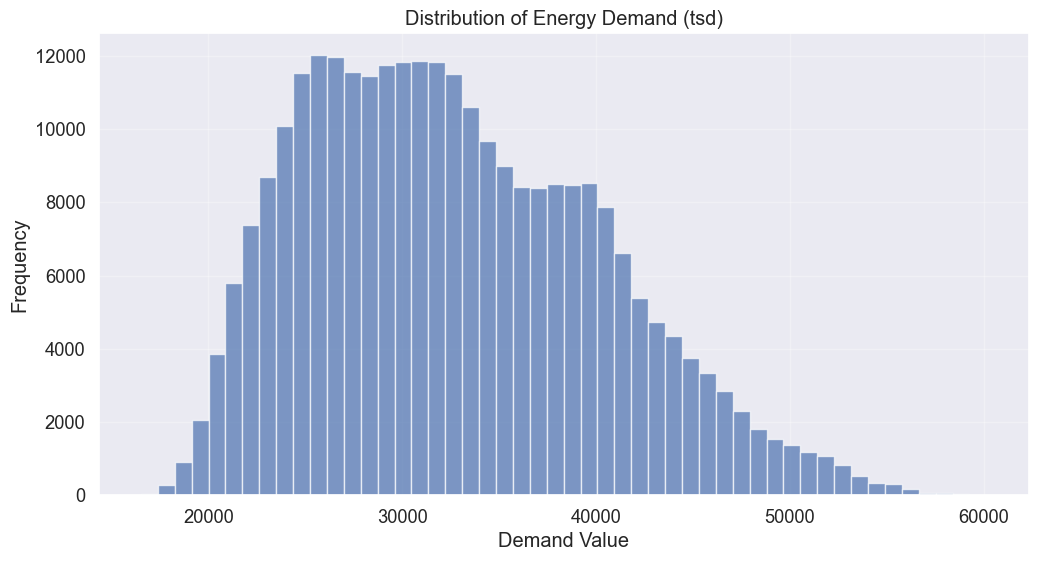

Generating correlation matrix heatmap...


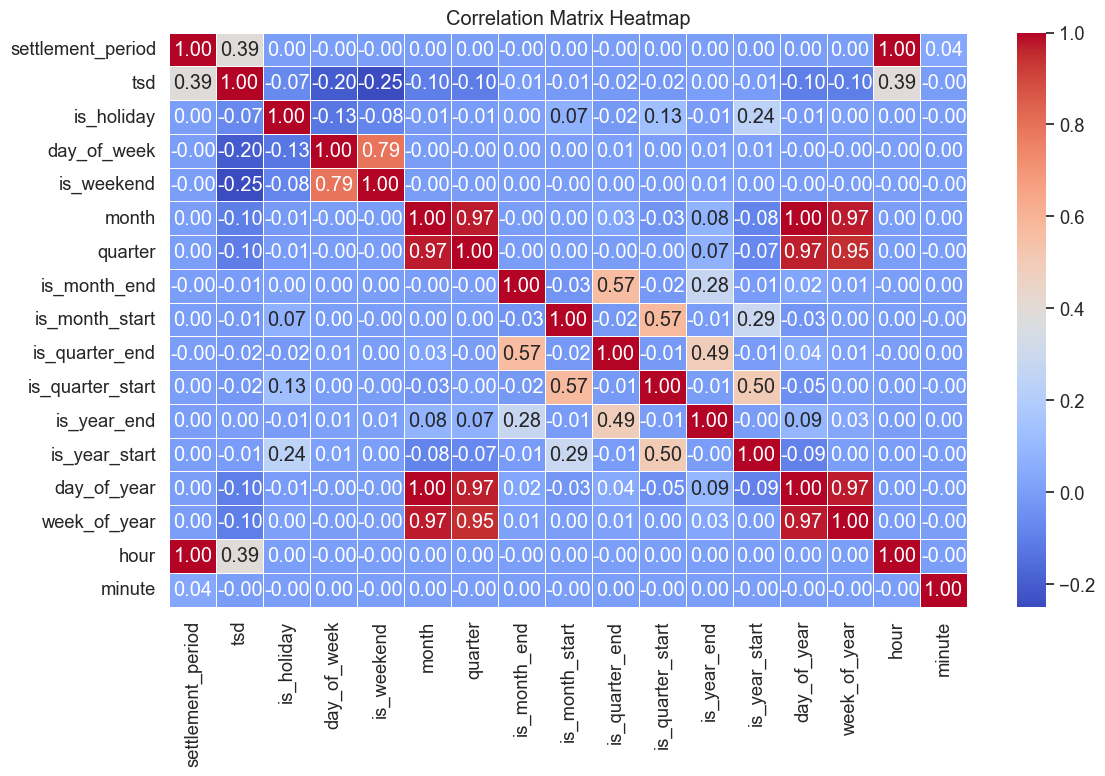

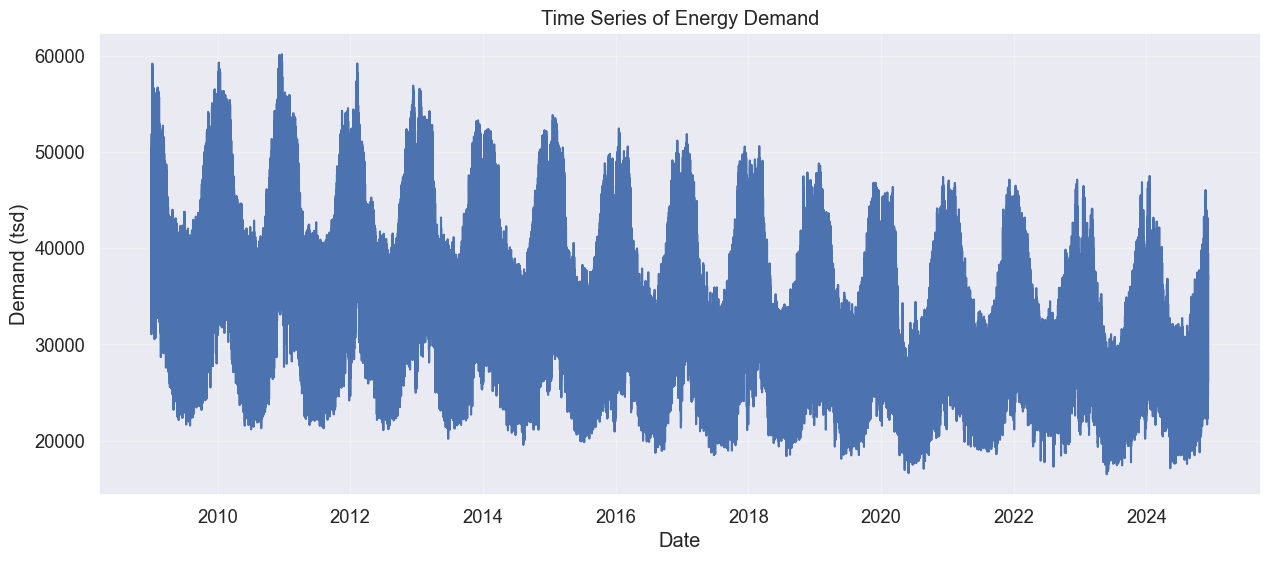

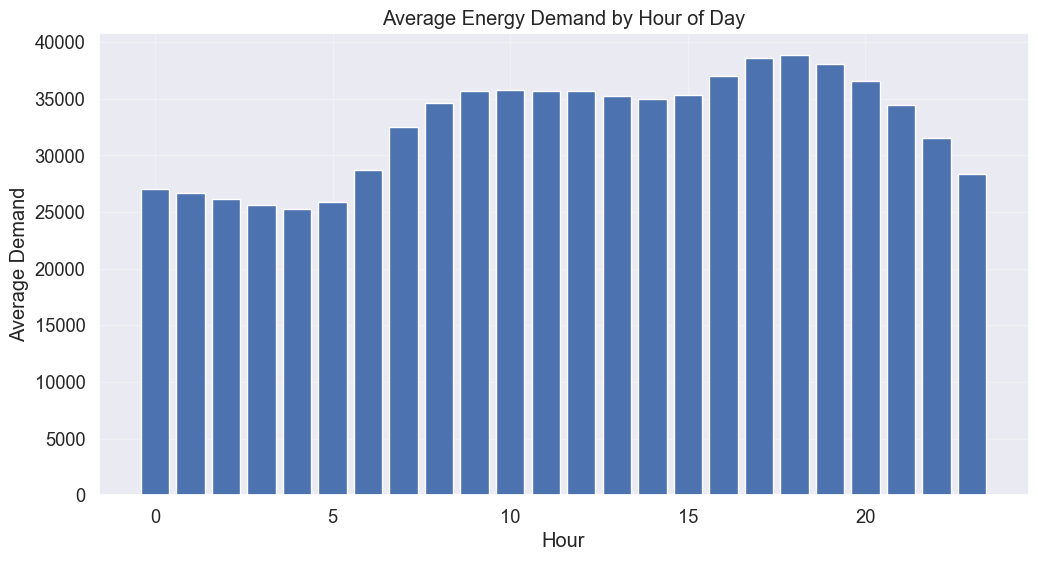

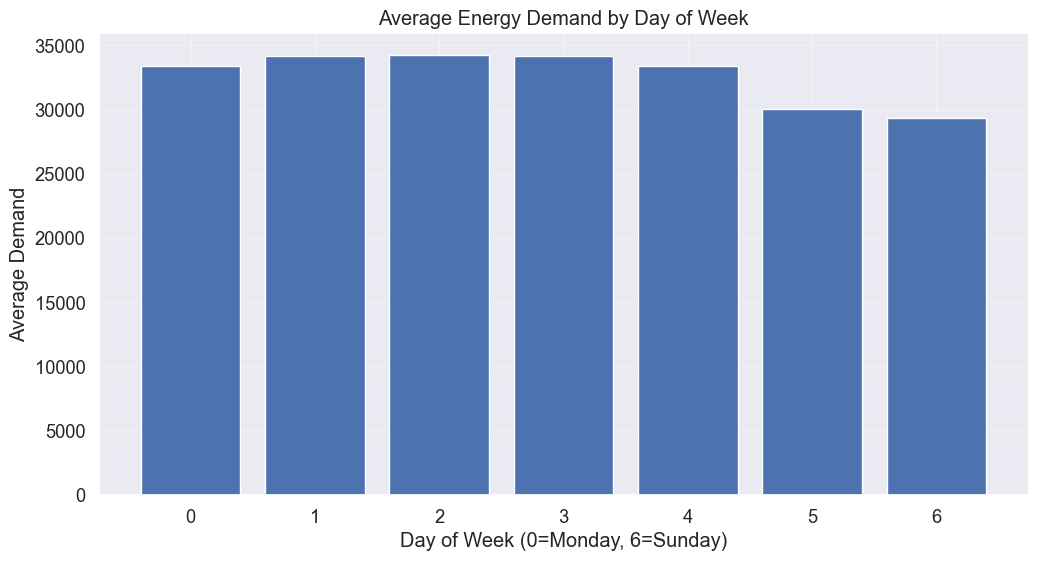

In [799]:

# Plot the distribution of the target variable (tsd)
plt.figure(figsize=(12, 6))
plt.hist(df['tsd'], bins=50, alpha=0.7)
plt.title('Distribution of Energy Demand (tsd)')
plt.xlabel('Demand Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.show()

# Display correlation matrix heatmap
print("Generating correlation matrix heatmap...")
corr_matrix = df.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

# Plot time series of the target variable
plt.figure(figsize=(15, 6))
plt.plot(df.index, df['tsd'])
plt.title('Time Series of Energy Demand')
plt.xlabel('Date')
plt.ylabel('Demand (tsd)')
plt.grid(True, alpha=0.3)
plt.show()

# Examine patterns by hour of day
hourly_avg = df.groupby(df.index.hour)['tsd'].mean()
plt.figure(figsize=(12, 6))
plt.bar(hourly_avg.index, hourly_avg.values)
plt.title('Average Energy Demand by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Average Demand')
plt.grid(True, alpha=0.3)
plt.show()

# Examine patterns by day of week
daily_avg = df.groupby('day_of_week')['tsd'].mean()
plt.figure(figsize=(12, 6))
plt.bar(daily_avg.index, daily_avg.values)
plt.title('Average Energy Demand by Day of Week')
plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Demand')
plt.grid(True, alpha=0.3)
plt.show()

## Prepare Data for Training

In [800]:

def train_test_split_ts(X, y, test_size=0.2):
    """
    Split time series data chronologically into train and test sets.

    Args:
        X (DataFrame): Feature dataframe
        y (Series): Target series
        test_size (float): Fraction of data to use for testing

    Returns:
        tuple: X_train, X_test, y_train, y_test
    """
    split_idx = int(len(X) * (1 - test_size))
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

    return X_train, X_test, y_train, y_test



Create lags for Forecasting

In [801]:

# def create_features(df, target_col, lag_periods=48, forecast_horizon=48):
#     """
#     Create lag features for time series forecasting.

#     Args:
#         df (DataFrame): Dataframe containing time series data
#         target_col (str): Target column to create lags for
#         lag_periods (int): Number of lag periods to create
#         forecast_horizon (int): Number of periods ahead to forecast

#     Returns:
#         tuple: (X, y) Feature dataframe and target series
#     """
#     # Create a copy of the dataframe to avoid modifying the original
#     data = df.copy()
    

#     # Create lag features
#     for lag in range(1, lag_periods + 1):
#         data[f'lag_{lag}'] = data[target_col].shift(lag)

#     # # Create the target variable (forecast_horizon steps ahead)
#     # data['target'] = data[target_col].shift(-forecast_horizon)

#     # Drop NaN values that result from shifting
#     data = data.dropna()

#     # Separate features and target
#     y = data['tsd']
#     X = data.drop('tsd', axis=1)

#     return X, y

In [802]:

def add_lags(train, test, target_col, lag_periods=48):
    """
    Create lag features for time series forecasting.

    Args:
        df (DataFrame): Dataframe containing time series data
        target_col (str): Target column to create lags for
        lag_periods (int): Number of lag periods to create
        forecast_horizon (int): Number of periods ahead to forecast

    Returns:
        tuple: (X, y) Feature dataframe and target series
    """
    # Create a copy of the dataframe to avoid modifying the original
    train = train.copy()
    test = test.copy()

    # Create lag features
    for lag in range(1, lag_periods + 1):
        train.loc[:, f'lag_{lag}'] = train[target_col].shift(lag)

    # Drop NaN values that result from shifting
    train = train.dropna()

    # Create lag columns in test set filled with NaN
    for lag in range(1, lag_periods + 1):
        test.loc[:, f'lag_{lag}'] = np.nan


    return train, test

Create different train and test sets

In [803]:
def walk_forward_validation(df, forecast_horizon=48, lag_periods=None, date_windows=None):
    """
    Create multiple train/test splits using walk-forward validation with specific dates.
    
    Args:
        X (DataFrame): Feature dataframe with datetime index
        y (Series): Target series with datetime index
        forecast_horizon (int): Number of periods to forecast
        n_windows (int): Not used when date_windows is provided, kept for compatibility
        date_windows (list): List of specific dates to use as window start points
        
    Returns:
        list: List of (X_train, X_test, y_train, y_test) tuples
    """
    splits = []
    
    # If specific dates are provided
    if date_windows is not None:
        print(f"\nCreating validation windows based on {len(date_windows)} specific dates")
        
        for i, start_date in enumerate(date_windows):
            print(f"Window {i+1}: Starting from {start_date}")
            
            # Find the closest index to the specified date
            try:
                # Get the closest date that exists in the index
                start_idx = df.index.get_indexer([pd.Timestamp(start_date)], method='nearest')[0]
                
                # Create the split
                train = df.iloc[:start_idx]
                test = df.iloc[start_idx:start_idx+forecast_horizon]
                
                if lag_periods:
                    train, test = add_lags(train, test, target_col='tsd', lag_periods=lag_periods)

                X_train, X_test = train.drop(columns=['tsd']), test.drop(columns=['tsd'])
                y_train, y_test = train['tsd'], test['tsd']

                print(f"  Train data: from {X_train.index.min()} to {X_train.index.max()} ({len(X_train)} samples)")
                print(f"  Test data: from {X_test.index.min()} to {X_test.index.max()} ({len(X_test)} samples)")
                
                if len(X_test) < forecast_horizon:
                    print(f"  Warning: Test set shorter than requested forecast horizon ({len(X_test)} < {forecast_horizon})")
                
                splits.append((X_train, X_test, y_train, y_test))
            
            except (IndexError, KeyError) as e:
                print(f"  Error creating window for date {start_date}: {str(e)}")
                continue
    
    else:
        # Fallback to the original implementation (random or evenly-spaced)
        print("No specific dates provided. Please provide date_windows parameter.")
        return []
    
    print(f"Created {len(splits)} validation windows with forecast horizon of {forecast_horizon}")
    
    return splits

In [804]:

def mean_absolute_percentage_error(y_true, y_pred):
    """
    Calculate Mean Absolute Percentage Error

    Args:
        y_true: True values
        y_pred: Predicted values

    Returns:
        MAPE value (percentage)
    """
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return mape


In [805]:

# Setting parameters for forecasting
TARGET_COL = 'tsd'
LAG_PERIODS = 48  # One day of lags
FORECAST_HORIZON = 48  # One day ahead forecast
TEST_SIZE = 0.2
SEED = 20

In [806]:
np.random.seed(SEED)
all_dates = pd.date_range(start='2019-06-01', end='2023-12-31', freq='D')
random_dates = np.random.choice(all_dates, size=10, replace=False)
date_windows = sorted([pd.Timestamp(d).strftime('%Y-%m-%d') for d in random_dates])
print("Randomly selected window start dates:", date_windows)

Randomly selected window start dates: ['2020-04-08', '2020-10-13', '2021-02-01', '2021-03-03', '2021-07-01', '2022-05-14', '2022-06-06', '2022-09-09', '2022-12-16', '2023-03-04']


### Direct Forecasting

#### Preparing the data

In [807]:
# Create splits using the date-based window selection
direct_splits = walk_forward_validation(df, forecast_horizon=FORECAST_HORIZON, date_windows=date_windows)


Creating validation windows based on 10 specific dates
Window 1: Starting from 2020-04-08
  Train data: from 2009-01-01 00:00:00 to 2020-04-07 23:30:00 (196776 samples)
  Test data: from 2020-04-08 00:00:00 to 2020-04-08 23:30:00 (48 samples)
Window 2: Starting from 2020-10-13
  Train data: from 2009-01-01 00:00:00 to 2020-10-12 23:30:00 (205800 samples)
  Test data: from 2020-10-13 00:00:00 to 2020-10-13 23:30:00 (48 samples)
Window 3: Starting from 2021-02-01
  Train data: from 2009-01-01 00:00:00 to 2021-01-31 23:30:00 (211128 samples)
  Test data: from 2021-02-01 00:00:00 to 2021-02-01 23:30:00 (48 samples)
Window 4: Starting from 2021-03-03
  Train data: from 2009-01-01 00:00:00 to 2021-03-02 23:30:00 (212568 samples)
  Test data: from 2021-03-03 00:00:00 to 2021-03-03 23:30:00 (48 samples)
Window 5: Starting from 2021-07-01
  Train data: from 2009-01-01 00:00:00 to 2021-06-30 23:30:00 (218326 samples)
  Test data: from 2021-07-01 00:00:00 to 2021-07-01 23:30:00 (48 samples)
Wind

In [808]:
xgb_params = {
    # 'objective': 'reg:squarederror',
    'n_estimators': 500,
    'learning_rate': 0.01,
    'max_depth': 3,
    'random_state': SEED,
    'early_stopping_rounds':50
}

#### Training

In [837]:
def run_direct(xgb_params, splits, exp_mode=False):
    print("\nTraining XGBoost model...")
    xgb_model = xgb.XGBRegressor(**xgb_params)

    # Start timing the training
    training_start_time = time.time()

    results_log = {}
    feature_importances = {}

    for i, (X_train, X_test, y_train, y_test) in enumerate(splits):
        X_train, X_val, y_train, y_val = train_test_split_ts(X_train, y_train, 0.2)
        # Train-test split for the current window
        print(f"\nTraining on window number {i + 1}...")

        # Train the model
        xgb_model.fit(
            X_train,
            y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],
            verbose=100
        )

        print(f"\nTesting on window number {i + 1}...")
        # Make predictions
        predictions = xgb_model.predict(X_test)

        if exp_mode:
            results_log[i] = {'preds': [], 'y_test': []}
            results_log[i]['preds'] = predictions
            results_log[i]['test'] = y_test
        
        else:
            # Calculate metrics
            mse = mean_squared_error(y_test, predictions)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, predictions)
            mape = mean_absolute_percentage_error(y_test, predictions)

            results_log[i] = {'mes': mse, 'rmse': rmse, 'mae': mae, 'mape': mape}
        feature_importances[i] = xgb_model.feature_importances_


    training_time = time.time() - training_start_time
    print(f"\nCompleted in {training_time:.2f} seconds")
    
    return results_log, feature_importances


In [810]:
direct_results, direct_feature_importances = run_direct(xgb_params, direct_splits)


Training XGBoost model...

Training on window number 1...
[0]	validation_0-rmse:7552.75841	validation_1-rmse:7744.88136
[100]	validation_0-rmse:4914.00556	validation_1-rmse:5949.44488
[200]	validation_0-rmse:3943.70346	validation_1-rmse:5509.35622
[300]	validation_0-rmse:3482.85628	validation_1-rmse:5361.74497
[400]	validation_0-rmse:3249.36876	validation_1-rmse:5313.58278
[499]	validation_0-rmse:3108.31438	validation_1-rmse:5296.46745

Testing on window number 1...

Training on window number 2...
[0]	validation_0-rmse:7531.20173	validation_1-rmse:8646.98901
[100]	validation_0-rmse:4929.47959	validation_1-rmse:6913.22747
[200]	validation_0-rmse:3977.23875	validation_1-rmse:6380.38160
[300]	validation_0-rmse:3531.42353	validation_1-rmse:6144.56219
[400]	validation_0-rmse:3311.74033	validation_1-rmse:6050.04855
[499]	validation_0-rmse:3171.91647	validation_1-rmse:5984.34726

Testing on window number 2...

Training on window number 3...
[0]	validation_0-rmse:7567.43605	validation_1-rmse:

#### Results

In [811]:
# Calculate average results across all windows
avg_mse = np.mean([result['mes'] for result in direct_results.values()])
avg_rmse = np.mean([result['rmse'] for result in direct_results.values()])
avg_mae = np.mean([result['mae'] for result in direct_results.values()])
avg_mape = np.mean([result['mape'] for result in direct_results.values()])
print("\nAverage Results Across All Windows:")
print(f"Average MSE: {avg_mse:.2f}")
print(f"Average RMSE: {avg_rmse:.2f}")
print(f"Average MAE: {avg_mae:.2f}")
print(f"Average MAPE: {avg_mape:.2f}%")


Average Results Across All Windows:
Average MSE: 28810020.12
Average RMSE: 4885.62
Average MAE: 4539.20
Average MAPE: 15.71%


In [812]:
# results_dict = {}
# for s in range(5, 50):
#     # Setting parameters for forecasting
#     TARGET_COL = 'tsd'
#     LAG_PERIODS = 48  # One day of lags
#     FORECAST_HORIZON = 48  # One day ahead forecast
#     TEST_SIZE = 0.2
#     SEED = s
#     np.random.seed(SEED)
#     all_dates = pd.date_range(start='2019-06-01', end='2023-12-31', freq='D')
#     random_dates = np.random.choice(all_dates, size=10, replace=False)
#     date_windows = sorted([pd.Timestamp(d).strftime('%Y-%m-%d') for d in random_dates])
#     print("Randomly selected window start dates:", date_windows)

#     direct_splits = walk_forward_validation(df, forecast_horizon=FORECAST_HORIZON, date_windows=date_windows)
#     xgb_params = {
#         # 'objective': 'reg:squarederror',
#         'n_estimators': 500,
#         'learning_rate': 0.01,
#         'max_depth': 3,
#         'random_state': SEED,
#         'early_stopping_rounds':50
#     }
#     direct_results, direct_feature_importances = run_direct(xgb_params, direct_splits)
#     # Save results in a dictionary for each seed
#     avg_mape = np.mean([result['mape'] for result in direct_results.values()])

#     results_dict[s] = avg_mape

#     # print(f"seed: {s}")
#     # print("\nAverage Results Across All Windows:")
#     # print(f"Average MSE: {avg_mse:.2f}")
#     # print(f"Average RMSE: {avg_rmse:.2f}")
#     # print(f"Average MAE: {avg_mae:.2f}")
#     # print(f"Average MAPE: {avg_mape:.2f}%")

In [813]:
# results_dict

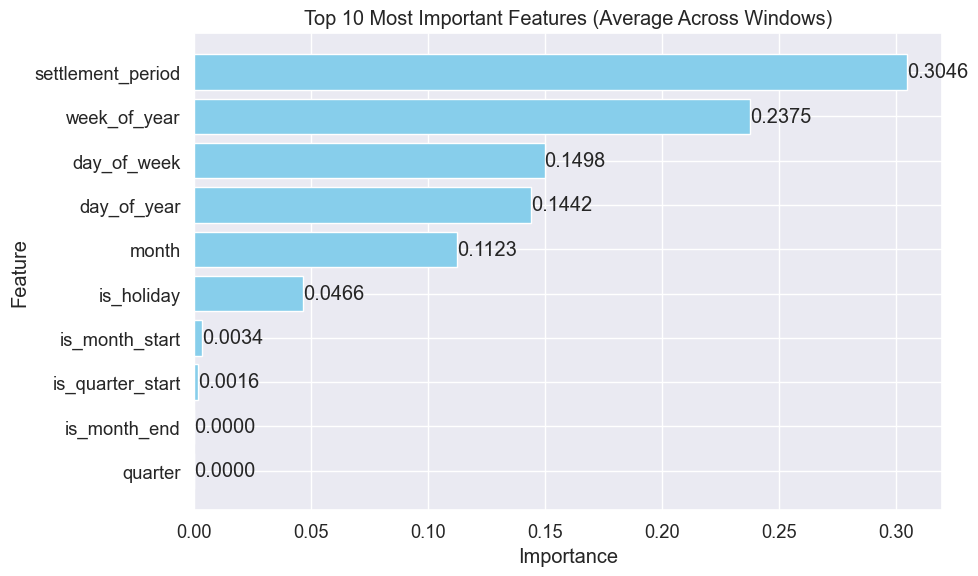

In [814]:
# Calculate the average feature importance across all windows
average_importances = np.mean(list(direct_feature_importances.values()), axis=0)

# Create a DataFrame with feature importances
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': average_importances
}).sort_values('Importance', ascending=False)

top_features_df = importance_df.head(10)

# Plot average feature importance for the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_features_df['Feature'], top_features_df['Importance'], color='skyblue')
plt.title("Top 10 Most Important Features (Average Across Windows)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature at the top

# Add labels to the bars
for index, value in enumerate(top_features_df['Importance']):
    plt.text(value, index, f"{value:.4f}", va='center')

plt.tight_layout()
plt.show()


### Recursive Forecasting

#### Preparing the data

In [815]:
# X, y = create_features(df, 'tsd', lag_periods=LAG_PERIODS, forecast_horizon=FORECAST_HORIZON)

In [816]:
# X, y = df.drop(columns=['tsd']), df['tsd']

In [817]:
rec_splits = walk_forward_validation(df, forecast_horizon=FORECAST_HORIZON, lag_periods=LAG_PERIODS, date_windows=date_windows)


Creating validation windows based on 10 specific dates
Window 1: Starting from 2020-04-08
  Train data: from 2009-01-02 00:00:00 to 2020-04-07 23:30:00 (196728 samples)
  Test data: from 2020-04-08 00:00:00 to 2020-04-08 23:30:00 (48 samples)
Window 2: Starting from 2020-10-13
  Train data: from 2009-01-02 00:00:00 to 2020-10-12 23:30:00 (205752 samples)
  Test data: from 2020-10-13 00:00:00 to 2020-10-13 23:30:00 (48 samples)
Window 3: Starting from 2021-02-01
  Train data: from 2009-01-02 00:00:00 to 2021-01-31 23:30:00 (211080 samples)
  Test data: from 2021-02-01 00:00:00 to 2021-02-01 23:30:00 (48 samples)
Window 4: Starting from 2021-03-03
  Train data: from 2009-01-02 00:00:00 to 2021-03-02 23:30:00 (212520 samples)
  Test data: from 2021-03-03 00:00:00 to 2021-03-03 23:30:00 (48 samples)
Window 5: Starting from 2021-07-01
  Train data: from 2009-01-02 00:00:00 to 2021-06-30 23:30:00 (218278 samples)
  Test data: from 2021-07-01 00:00:00 to 2021-07-01 23:30:00 (48 samples)
Wind

In [818]:
xgb_params = {
    # 'objective': 'reg:squarederror',
    'n_estimators': 500,
    'learning_rate': 0.01,
    'max_depth': 3,
    'random_state': SEED,
    # 'early_stopping_rounds':50
}

#### Training

In [819]:
def recursive_forecast(model, X_test, last_train_record, last_train_record_tsd):
    """
    Make recursive forecasts using an XGBoost model.

    This function makes multi-step forecasts by using each prediction as
    an input feature for the next prediction (recursive approach).

    Args:
        model (XGBRegressor): Trained XGBoost model
        X_test (DataFrame): Test data with features
        last_train_record (DataFrame): Last record from training data
        last_train_record_tsd (float): Last observed target value

    Returns:
        list: Forecasted values for the entire forecast horizon
    """
    # Array to store forecasts
    forecasts = []
    
    # Get the lag feature names and sort them numerically
    lag_cols = [col for col in X_test.columns if 'lag_' in col]
    lag_cols.sort(key=lambda x: int(x.split('_')[1]))
    
    # Create a dictionary to store lag values (will be updated with each prediction)
    lag_values = {}
    
    # Initialize lag values from the last training record
    for i, col in enumerate(lag_cols):
        if i == 0:  # The most recent lag needs the last known target value
            lag_values[col] = last_train_record_tsd
        else:
            # Get values from the last training record for all other lags
            lag_values[col] = last_train_record[lag_cols[i-1]].values[0]
    
    # Make predictions for each time step in the test set
    for i in range(len(X_test)):
        # Create a copy of the current test row
        curr_row = X_test.iloc[i:i+1].copy()
        
        # Update the lag features with our values
        for col in lag_cols:
            curr_row[col] = lag_values[col]
        
        # Make the prediction
        pred = model.predict(curr_row)[0]
        forecasts.append(pred)
        
        # Update lag values for the next step
        # Shift all lags one position (lag_1 becomes lag_2, etc.)
        for j in range(len(lag_cols)-1, 0, -1):
            lag_values[lag_cols[j]] = lag_values[lag_cols[j-1]]
        
        # The newest prediction becomes lag_1
        lag_values[lag_cols[0]] = pred
    
    return forecasts

In [836]:
def run_recursive(xgb_params, splits, exp_mode = False):
    print("\nPerforming recursive forecasting...")

    # Start timing recursive forecasting
    recursive_start_time = time.time()
    results_log = {}
    feature_importances = {}
    
    for i, (X_train, X_test, y_train, y_test) in enumerate(splits):
        xgb_model = xgb.XGBRegressor(**xgb_params)
        
        # Train the model
        xgb_model.fit(
            X_train,
            y_train,
            verbose=False
        )
        
        # Store feature importances for this window
        feature_importances[i] = xgb_model.feature_importances_  # Add this line
        
        # Make recursive forecasts
        recursive_preds = recursive_forecast(xgb_model, X_test, X_train.iloc[[-1]], y_train.values[-1])
        if exp_mode:
            results_log[i] = {'preds': [], 'y_test': []}
            results_log[i]['preds'] = recursive_preds
            results_log[i]['test'] = y_test
        
        else:
            # Calculate metrics
            mse = mean_squared_error(y_test, recursive_preds)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test, recursive_preds)
            mape = mean_absolute_percentage_error(y_test, recursive_preds)

            results_log[i] = {'mes': mse, 'rmse': rmse, 'mae': mae, 'mape': mape}
    
    recursive_time = time.time() - recursive_start_time
    print(f"Recursive forecasting completed in {recursive_time:.2f} seconds")
    
    return results_log, feature_importances  # Modified to return feature importances too

In [821]:
recursive_results, rec_feature_importances = run_recursive(xgb_params, rec_splits)


Performing recursive forecasting...
Recursive forecasting completed in 169.81 seconds


#### Results

In [822]:
# Calculate average results across all windows
rec_avg_mse = np.mean([result['mes'] for result in recursive_results.values()])
rec_avg_rmse = np.mean([result['rmse'] for result in recursive_results.values()])
rec_avg_mae = np.mean([result['mae'] for result in recursive_results.values()])
rec_avg_mape = np.mean([result['mape'] for result in recursive_results.values()])
print("\nAverage Results Across All Windows:")
print(f"Average MSE: {rec_avg_mse:.2f}")
print(f"Average RMSE: {rec_avg_rmse:.2f}")
print(f"Average MAE: {rec_avg_mae:.2f}")
print(f"Average MAPE: {rec_avg_mape:.2f}%")


Average Results Across All Windows:
Average MSE: 3331619.24
Average RMSE: 1745.65
Average MAE: 1424.47
Average MAPE: 4.70%


In [823]:
len(average_importances)

16

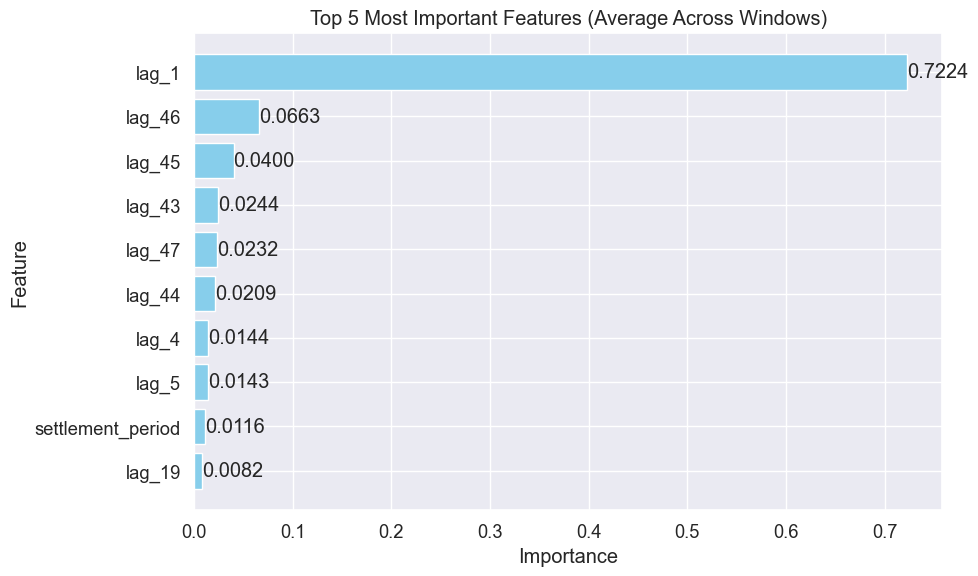

In [824]:
# Calculate the average feature importance across all windows
average_importances = np.mean(list(rec_feature_importances.values()), axis=0)

# Create a DataFrame with feature importances
importance_df = pd.DataFrame({
    'Feature': ['settlement_period', 'is_holiday', 'day_of_week', 'is_weekend', 'month', 'quarter', 'is_month_end', 'is_month_start', 'is_quarter_end', 'is_quarter_start', 'is_year_end', 'is_year_start', 'day_of_year', 'week_of_year', 'hour', 'minute', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5', 'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12', 'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19', 'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24', 'lag_25', 'lag_26', 'lag_27', 'lag_28', 'lag_29', 'lag_30', 'lag_31', 'lag_32', 'lag_33', 'lag_34', 'lag_35', 'lag_36', 'lag_37', 'lag_38', 'lag_39', 'lag_40', 'lag_41', 'lag_42', 'lag_43', 'lag_44', 'lag_45', 'lag_46', 'lag_47', 'lag_48'],
    'Importance': average_importances
}).sort_values('Importance', ascending=False)

top_features_df = importance_df.head(10)

# Plot average feature importance for the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_features_df['Feature'], top_features_df['Importance'], color='skyblue')
plt.title("Top 5 Most Important Features (Average Across Windows)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature at the top

# Add labels to the bars
for index, value in enumerate(top_features_df['Importance']):
    plt.text(value, index, f"{value:.4f}", va='center')

plt.tight_layout()
plt.show()


### Forcaster Recursive

#### Preparing the data

In [825]:
sk_df = df.resample("30min").sum()

In [826]:
sk_splits = walk_forward_validation(sk_df, forecast_horizon=FORECAST_HORIZON, date_windows=date_windows)


Creating validation windows based on 10 specific dates
Window 1: Starting from 2020-04-08
  Train data: from 2009-01-01 00:00:00 to 2020-04-07 23:30:00 (197520 samples)
  Test data: from 2020-04-08 00:00:00 to 2020-04-08 23:30:00 (48 samples)
Window 2: Starting from 2020-10-13
  Train data: from 2009-01-01 00:00:00 to 2020-10-12 23:30:00 (206544 samples)
  Test data: from 2020-10-13 00:00:00 to 2020-10-13 23:30:00 (48 samples)
Window 3: Starting from 2021-02-01
  Train data: from 2009-01-01 00:00:00 to 2021-01-31 23:30:00 (211872 samples)
  Test data: from 2021-02-01 00:00:00 to 2021-02-01 23:30:00 (48 samples)
Window 4: Starting from 2021-03-03
  Train data: from 2009-01-01 00:00:00 to 2021-03-02 23:30:00 (213312 samples)
  Test data: from 2021-03-03 00:00:00 to 2021-03-03 23:30:00 (48 samples)
Window 5: Starting from 2021-07-01
  Train data: from 2009-01-01 00:00:00 to 2021-06-30 23:30:00 (219072 samples)
  Test data: from 2021-07-01 00:00:00 to 2021-07-01 23:30:00 (48 samples)
Wind

### Training

In [838]:
def run_forecaster(xgb_params, sk_splits, exp_mode=False):
    print("\nTraining SKForecast ForecasterRecursive model...")
    results_log = {}
    sk_start_time = time.time()
    feature_importances = {} 
    for i, (X_train_forecaster, X_test_forecaster, y_train_forecaster, y_test_forecaster) in enumerate(sk_splits):
        print(f"\nTraining on window number {i + 1}...")

        regressor = xgb.XGBRegressor(**xgb_params)
        lags_grid = list(range(1, LAG_PERIODS + 1))

        # Initialize the forecaster
        forecaster = ForecasterRecursive(
            regressor=regressor,
            lags=lags_grid
        )
        forecaster.fit(y=y_train_forecaster, exog=X_train_forecaster)
        
        # Extract feature importances from the forecaster's regressor
        # In SKForecast, we need to access the regressor within the forecaster
        model_importances = forecaster.regressor.feature_importances_
        
        # Store feature importances - we need to map them to feature names
        # SKForecast organizes features differently so we need to extract the mapping
        exog_names = X_train_forecaster.columns.tolist() if X_train_forecaster is not None else []
        lag_names = [f'lag_{i}' for i in lags_grid]
        all_features = lag_names + exog_names  # Combined feature names
        
        # Store the feature importances - need to map them to the correct features
        feature_importances[i] = {name: imp for name, imp in 
                                zip(all_features, model_importances)}

        print(f"\nTesting on window number {i + 1}...")

        preds = forecaster.predict(
            steps=FORECAST_HORIZON,
            exog=X_test_forecaster
        )
        
        if exp_mode:
            results_log[i] = {'preds': [], 'y_test': []}
            results_log[i]['preds'] = preds
            results_log[i]['test'] = y_test_forecaster
        
        else:
            # Calculate metrics
            mse = mean_squared_error(y_test_forecaster, preds)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(y_test_forecaster, preds)
            mape = mean_absolute_percentage_error(y_test_forecaster, preds)

            results_log[i] = {'mes': mse, 'rmse': rmse, 'mae': mae, 'mape': mape}

    sk_time = time.time() - sk_start_time
    print(f"SKForecast Recursive forecasting completed in {sk_time:.2f} seconds")

    return results_log, feature_importances  # Return feature importances too

In [828]:
forecaster_results, forecaster_feature_importances = run_forecaster(xgb_params, sk_splits)


Training SKForecast ForecasterRecursive model...

Training on window number 1...

Testing on window number 1...

Training on window number 2...

Testing on window number 2...

Training on window number 3...

Testing on window number 3...

Training on window number 4...

Testing on window number 4...

Training on window number 5...

Testing on window number 5...

Training on window number 6...

Testing on window number 6...

Training on window number 7...

Testing on window number 7...

Training on window number 8...

Testing on window number 8...

Training on window number 9...

Testing on window number 9...

Training on window number 10...

Testing on window number 10...
SKForecast Recursive forecasting completed in 172.23 seconds


### Results

In [829]:
# Calculate average results across all windows
sk_avg_mse = np.mean([result['mes'] for result in forecaster_results.values()])
sk_avg_rmse = np.mean([result['rmse'] for result in forecaster_results.values()])
sk_avg_mae = np.mean([result['mae'] for result in forecaster_results.values()])
sk_avg_mape = np.mean([result['mape'] for result in forecaster_results.values()])  
print("\nAverage Results Across All Windows:")
print(f"Average MSE: {sk_avg_mse:.2f}")
print(f"Average RMSE: {sk_avg_rmse:.2f}")
print(f"Average MAE: {sk_avg_mae:.2f}")
print(f"Average MAPE: {sk_avg_mape:.2f}%")



Average Results Across All Windows:
Average MSE: 3720141.33
Average RMSE: 1826.44
Average MAE: 1507.34
Average MAPE: 4.99%


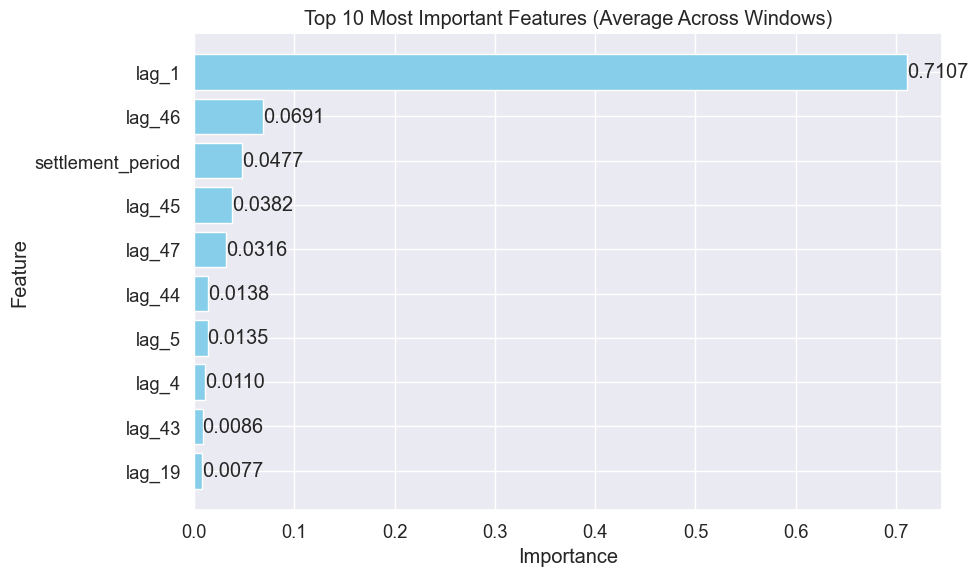

In [830]:


# Convert the feature_importances dict of dicts to a DataFrame
fi_df = pd.DataFrame(forecaster_feature_importances).T  # shape: (n_windows, n_features)

# Compute the mean importance for each feature
average_importances = fi_df.mean(axis=0)

# Create a DataFrame with feature importances
importance_df = pd.DataFrame({
    'Feature': average_importances.index,
    'Importance': average_importances.values
}).sort_values('Importance', ascending=False)

top_features_df = importance_df.head(10)

# Plot average feature importance for the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(top_features_df['Feature'], top_features_df['Importance'], color='skyblue')
plt.title("Top 10 Most Important Features (Average Across Windows)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.gca().invert_yaxis()  # Invert y-axis to display the most important feature at the top

# Add labels to the bars
for index, value in enumerate(top_features_df['Importance']):
    plt.text(value, index, f"{value:.4f}", va='center')

plt.tight_layout()
plt.show()

## Model Comparison
Comparing the performance of different forecasting models

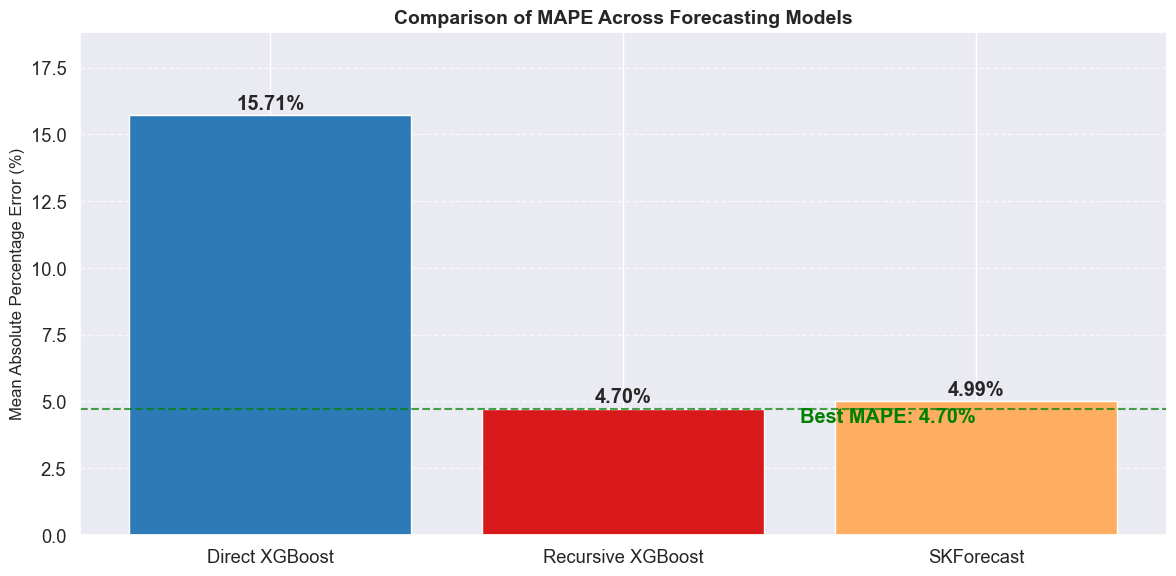

In [831]:
# Create bar chart to compare MAPE results across different models
plt.figure(figsize=(12, 6))

# Collect MAPE results from all models
model_names = ['Direct XGBoost', 'Recursive XGBoost', 'SKForecast']
model_mapes = [avg_mape, rec_avg_mape, sk_avg_mape]

# Create bar chart
bars = plt.bar(model_names, model_mapes, color=['#2C7BB6', '#D7191C', '#FDAE61'])

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.1,
            f'{height:.2f}%', ha='center', va='bottom', fontweight='bold')

# Add chart details
plt.title('Comparison of MAPE Across Forecasting Models', fontsize=14, fontweight='bold')
plt.ylabel('Mean Absolute Percentage Error (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.ylim(0, max(model_mapes) * 1.2)  # Set y-axis limit with some headroom

# Add a horizontal line for the best model's MAPE
best_mape = min(model_mapes)
plt.axhline(y=best_mape, color='green', linestyle='--', alpha=0.7)
plt.text(len(model_names)-1, best_mape - 0.5, f'Best MAPE: {best_mape:.2f}%', 
         color='green', fontweight='bold', ha='right')

plt.tight_layout()
plt.show()

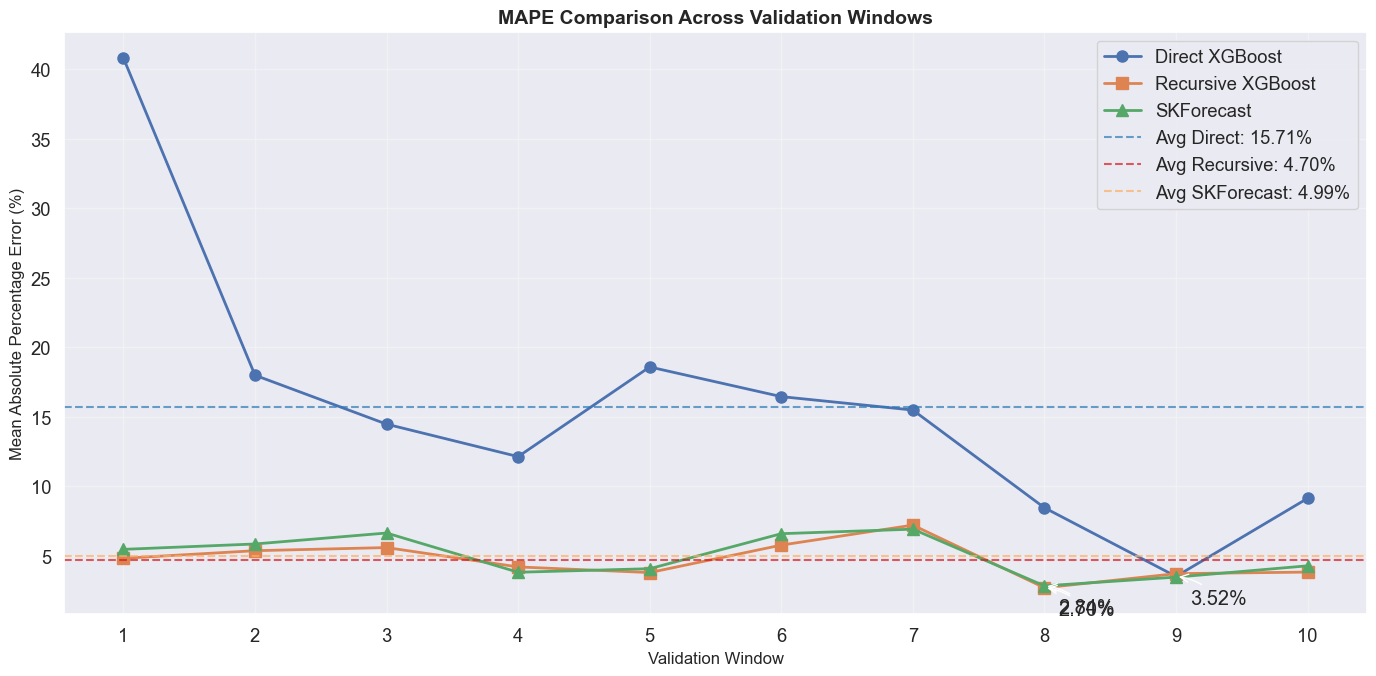

In [832]:
# Compare MAPE values across all validation windows

# Create lists of MAPE values for each model across all validation windows
direct_mapes = [result['mape'] for result in direct_results.values()]
recursive_mapes = [result['mape'] for result in recursive_results.values()]
forecaster_mapes = [result['mape'] for result in forecaster_results.values()]

# Extract window numbers
window_numbers = list(range(1, len(direct_mapes) + 1))

# Create the line plot
plt.figure(figsize=(14, 7))

# Plot MAPE for each model
plt.plot(window_numbers, direct_mapes, 'o-', label='Direct XGBoost', linewidth=2, markersize=8)
plt.plot(window_numbers, recursive_mapes, 's-', label='Recursive XGBoost', linewidth=2, markersize=8)
plt.plot(window_numbers, forecaster_mapes, '^-', label='SKForecast', linewidth=2, markersize=8)

# Add horizontal lines for average MAPE
plt.axhline(y=avg_mape, color='#2C7BB6', linestyle='--', alpha=0.7, 
           label=f'Avg Direct: {avg_mape:.2f}%')
plt.axhline(y=rec_avg_mape, color='#D7191C', linestyle='--', alpha=0.7, 
           label=f'Avg Recursive: {rec_avg_mape:.2f}%')
plt.axhline(y=sk_avg_mape, color='#FDAE61', linestyle='--', alpha=0.7, 
           label=f'Avg SKForecast: {sk_avg_mape:.2f}%')

# Add chart details
plt.title('MAPE Comparison Across Validation Windows', fontsize=14, fontweight='bold')
plt.xlabel('Validation Window', fontsize=12)
plt.ylabel('Mean Absolute Percentage Error (%)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='best')
plt.xticks(window_numbers)

# Add value annotations for the best and worst windows
direct_best_idx = direct_mapes.index(min(direct_mapes))
direct_worst_idx = direct_mapes.index(max(direct_mapes))

rec_best_idx = recursive_mapes.index(min(recursive_mapes))
rec_worst_idx = recursive_mapes.index(max(recursive_mapes))

sk_best_idx = forecaster_mapes.index(min(forecaster_mapes))
sk_worst_idx = forecaster_mapes.index(max(forecaster_mapes))

# Add annotations for best points
plt.annotate(f'{min(direct_mapes):.2f}%', 
            (window_numbers[direct_best_idx], direct_mapes[direct_best_idx]),
            xytext=(10, -20), textcoords='offset points', 
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

plt.annotate(f'{min(recursive_mapes):.2f}%', 
            (window_numbers[rec_best_idx], recursive_mapes[rec_best_idx]),
            xytext=(10, -20), textcoords='offset points', 
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

plt.annotate(f'{min(forecaster_mapes):.2f}%', 
            (window_numbers[sk_best_idx], forecaster_mapes[sk_best_idx]),
            xytext=(10, -20), textcoords='offset points', 
            arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

plt.tight_layout()
plt.show()

## Experiment with Different Forecast Horizons
Comparing model performance across multiple prediction horizons (48, 96, and 144 periods)

In [839]:
def run_horizon_experiment(df, horizon, dates):
    """
    Run a complete experiment with all models for a specific forecast horizon
    
    Args:
        horizon (int): The forecast horizon to use (number of periods to forecast)
        dates (list): List of specific dates to use as window start points
        
    Returns:
        dict: Dictionary containing results from all models
    """
    print(f"\n{'='*50}")
    print(f"Running experiment with forecast horizon: {horizon}")
    print(f"{'='*50}\n")
    
    # Store the current forecast horizon
    global FORECAST_HORIZON
    original_horizon = FORECAST_HORIZON
    FORECAST_HORIZON = horizon
    
    # direct_X = df.drop(columns=['tsd'])
    # direct_y = df['tsd']
    # Create validation windows
    direct_horizon_splits = walk_forward_validation(df, 
                                          forecast_horizon=horizon, 
                                          date_windows=dates)
    
    # Create features with the current lag periods and new forecast horizon
    # rec_X, rec_y = create_features(df, TARGET_COL, LAG_PERIODS, horizon)
    
    # Create validation windows
    rec_horizon_splits = walk_forward_validation(df, 
                                          forecast_horizon=horizon,  lag_periods=LAG_PERIODS,
                                          date_windows=dates)
    
    # Resample data for SKForecast
    sk_df = df.resample("30min").sum()

    # Create validation windows for SKForecast
    sk_splits_horizon = walk_forward_validation(sk_df,
                                             forecast_horizon=horizon, 
                                             date_windows=dates)
    
    # Run all three models
    print("\nRunning Direct Forecasting...")
    direct_results_horizon, direct_fi_horizon = run_direct(xgb_params, direct_horizon_splits, exp_mode=True)
    
    print("\nRunning Recursive Forecasting...")
    recursive_results_horizon, recursive_fi_horizon = run_recursive(xgb_params, rec_horizon_splits, exp_mode=True)
    
    print("\nRunning SKForecast...")
    forecaster_results_horizon, forecaster_fi_horizon = run_forecaster(xgb_params, sk_splits_horizon, exp_mode=True)
    
    # Return all results
    return {
        'direct': {'results': direct_results_horizon, 
                   'feature_importances': direct_fi_horizon},
        'recursive': {'results': recursive_results_horizon, 
                      'feature_importances': recursive_fi_horizon},
        'skforecast': {'results': forecaster_results_horizon, 
                       'feature_importances': forecaster_fi_horizon}
    }

In [840]:
horizons_to_run = []

all_results = run_horizon_experiment(df, 48*21, date_windows)


Running experiment with forecast horizon: 1008


Creating validation windows based on 10 specific dates
Window 1: Starting from 2020-04-08
  Train data: from 2009-01-01 00:00:00 to 2020-04-07 23:30:00 (196776 samples)
  Test data: from 2020-04-08 00:00:00 to 2020-04-28 23:30:00 (1008 samples)
Window 2: Starting from 2020-10-13
  Train data: from 2009-01-01 00:00:00 to 2020-10-12 23:30:00 (205800 samples)
  Test data: from 2020-10-13 00:00:00 to 2020-11-02 23:30:00 (1008 samples)
Window 3: Starting from 2021-02-01
  Train data: from 2009-01-01 00:00:00 to 2021-01-31 23:30:00 (211128 samples)
  Test data: from 2021-02-01 00:00:00 to 2021-02-21 23:30:00 (1008 samples)
Window 4: Starting from 2021-03-03
  Train data: from 2009-01-01 00:00:00 to 2021-03-02 23:30:00 (212568 samples)
  Test data: from 2021-03-03 00:00:00 to 2021-03-23 23:30:00 (1008 samples)
Window 5: Starting from 2021-07-01
  Train data: from 2009-01-01 00:00:00 to 2021-06-30 23:30:00 (218326 samples)
  Test data: from 202

In [853]:
finals_metrics = {'direct': {}, 'recursive': {}, 'skforecast': {}}
metrics = {}
number_of_horizons = 21
for type, val in all_results.items():
    # curr_dict = val['results']
    for horizon in range(1, number_of_horizons + 1):
        metrics = {}
        for window in range(10):
            curr_results = val['results'][window]
            preds = curr_results['preds'][:48*horizon]
            test = curr_results['test'][:48*horizon]
            # Calculate metrics
            mse = mean_squared_error(test, preds)
            rmse = np.sqrt(mse)
            mae = mean_absolute_error(test, preds)
            mape = mean_absolute_percentage_error(test, preds)

            metrics[window] = {'mes': mse, 'rmse': rmse, 'mae': mae, 'mape': mape}
        finals_metrics[type][48*horizon] = {
            'mse': np.mean([result['mes'] for result in metrics.values()]),
            'rmse': np.mean([result['rmse'] for result in metrics.values()]),
            'mae': np.mean([result['mae'] for result in metrics.values()]),
            'mape': np.mean([result['mape'] for result in metrics.values()])
        }

## Results Comparison Across Different Forecast Horizons
Analyzing how model performance changes with increasing forecast horizons

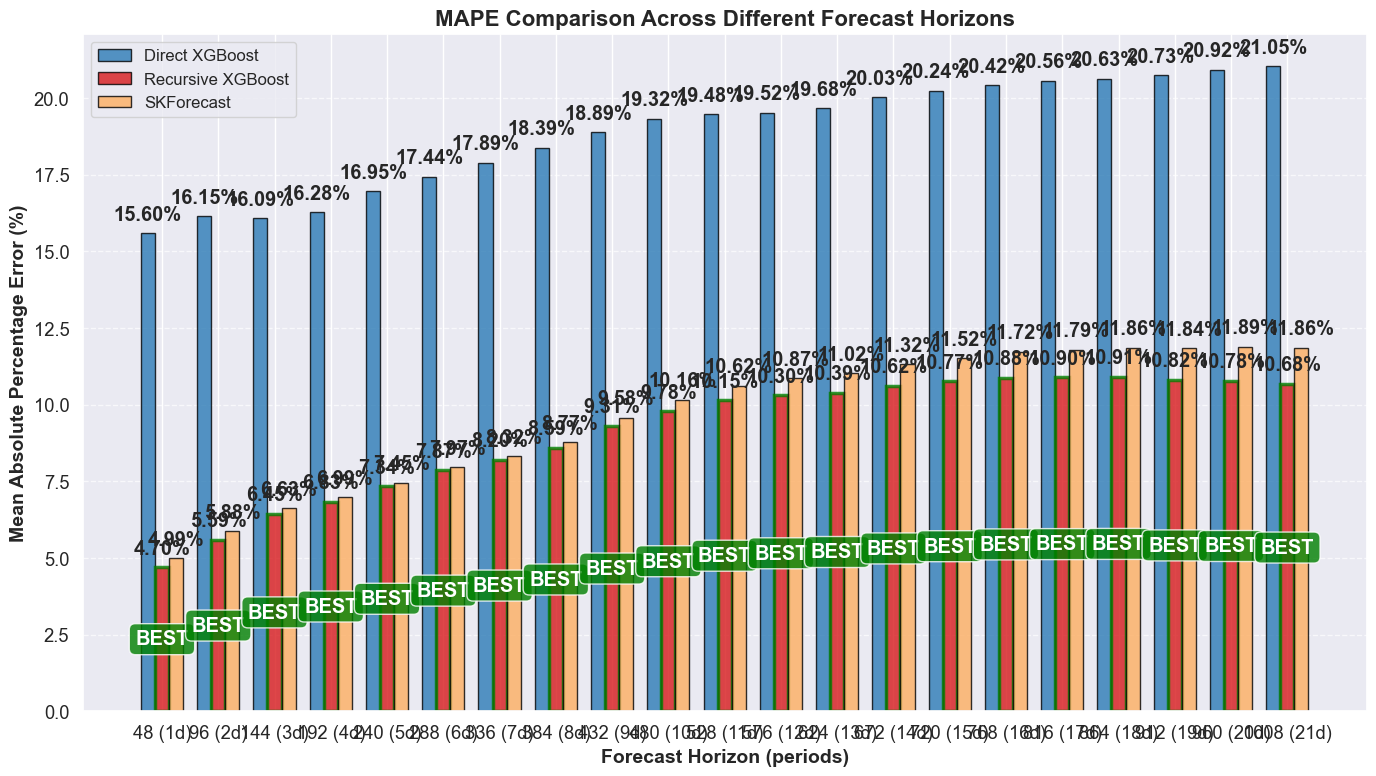

In [859]:
# Create a grouped bar chart to compare MAPE across different horizons and models using finals_metrics

# Extract unique forecast horizons and sort them
horizons = sorted([h for h in finals_metrics['direct'].keys()])
model_names = ['Direct XGBoost', 'Recursive XGBoost', 'SKForecast']

# Create lists to store MAPE values
direct_mapes = [finals_metrics['direct'][h]['mape'] for h in horizons]
recursive_mapes = [finals_metrics['recursive'][h]['mape'] for h in horizons]
skforecast_mapes = [finals_metrics['skforecast'][h]['mape'] for h in horizons]

# Set up the plot
plt.figure(figsize=(14, 8))

# Set width of bars
bar_width = 0.25

# Set positions of bars on X axis
r1 = np.arange(len(horizons))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Create bars
bars1 = plt.bar(r1, direct_mapes, width=bar_width, label='Direct XGBoost', color='#2C7BB6', edgecolor='black', alpha=0.8)
bars2 = plt.bar(r2, recursive_mapes, width=bar_width, label='Recursive XGBoost', color='#D7191C', edgecolor='black', alpha=0.8)
bars3 = plt.bar(r3, skforecast_mapes, width=bar_width, label='SKForecast', color='#FDAE61', edgecolor='black', alpha=0.8)

# Add values on top of bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.3,
                f'{height:.2f}%', ha='center', va='bottom', fontweight='bold')

add_labels(bars1)
add_labels(bars2)
add_labels(bars3)

# Add labels and title
plt.xlabel('Forecast Horizon (periods)', fontsize=14, fontweight='bold')
plt.ylabel('Mean Absolute Percentage Error (%)', fontsize=14, fontweight='bold')
plt.title('MAPE Comparison Across Different Forecast Horizons', fontsize=16, fontweight='bold')

# Format x-tick labels to show days instead of periods
horizon_days = [h // 48 for h in horizons]  # Convert periods to days (48 periods = 1 day)
plt.xticks([r + bar_width for r in range(len(horizons))], 
           [f"{h} ({d}d)" for h, d in zip(horizons, horizon_days)])

plt.legend(fontsize=12)

# Add grid
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Highlight the best model for each horizon
for i, horizon in enumerate(horizons):
    # Get MAPE values for this horizon
    h_mapes = [direct_mapes[i], recursive_mapes[i], skforecast_mapes[i]]
    best_idx = h_mapes.index(min(h_mapes))
    
    # Determine which bar to highlight
    bars = [bars1[i], bars2[i], bars3[i]]
    best_bar = bars[best_idx]
    
    # Highlight the best bar
    best_bar.set_edgecolor('green')
    best_bar.set_linewidth(2.5)
    
    # Add a text annotation
    plt.text(best_bar.get_x() + best_bar.get_width()/2., best_bar.get_height()/2.,
            'BEST', ha='center', va='center', fontweight='bold', color='white',
            bbox=dict(facecolor='green', alpha=0.8, boxstyle='round,pad=0.3'))

plt.tight_layout()
plt.show()

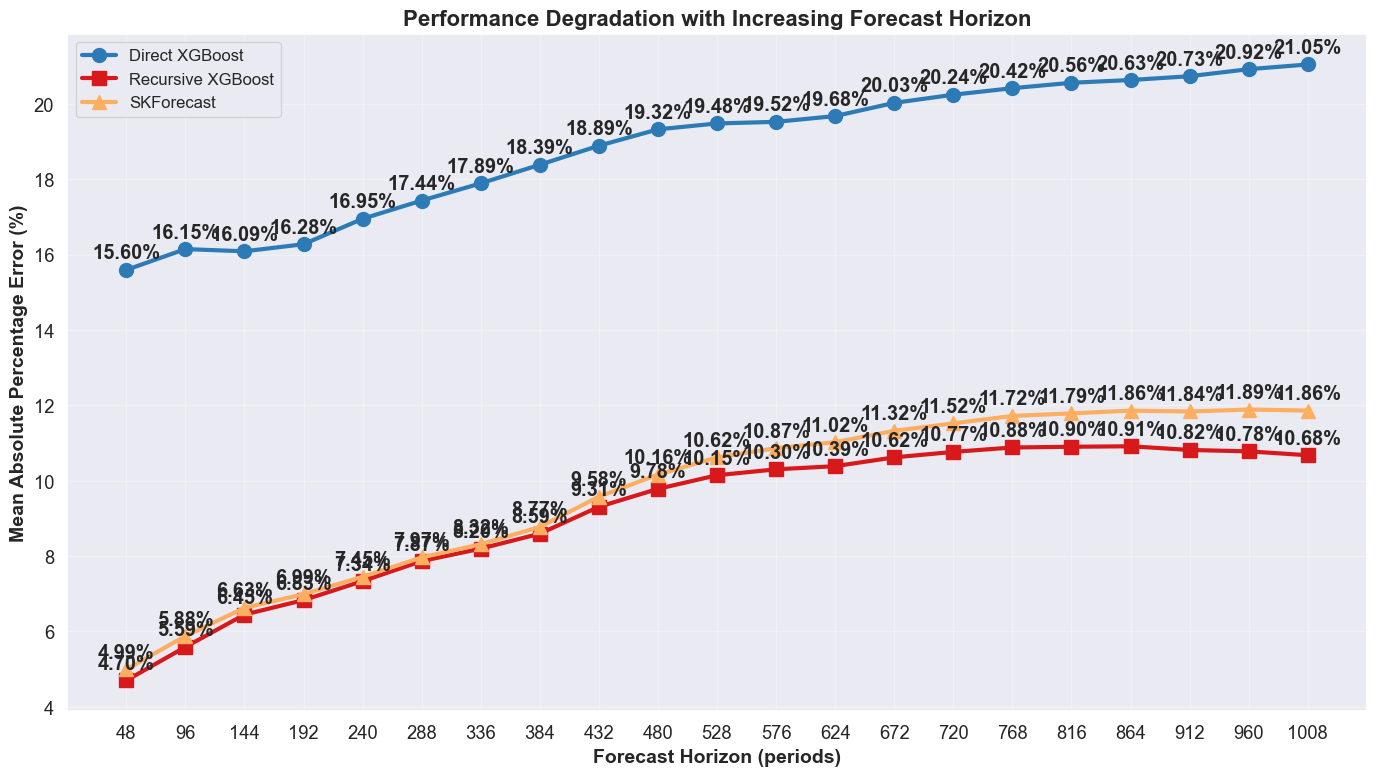

In [ ]:
# Create a line plot to visualize the trend in performance as horizon increases
plt.figure(figsize=(14, 8))

# Plot lines for each model
plt.plot(horizons, direct_mapes, marker='o', markersize=10, linewidth=3, label='Direct XGBoost', color='#2C7BB6')
plt.plot(horizons, recursive_mapes, marker='s', markersize=10, linewidth=3, label='Recursive XGBoost', color='#D7191C')
plt.plot(horizons, skforecast_mapes, marker='^', markersize=10, linewidth=3, label='SKForecast', color='#FDAE61')

# Add data points with values
for i, h in enumerate(horizons):
    plt.text(h, direct_mapes[i]+0.3, f'{direct_mapes[i]:.2f}%', ha='center', fontweight='bold')
    plt.text(h, recursive_mapes[i]+0.3, f'{recursive_mapes[i]:.2f}%', ha='center', fontweight='bold')
    plt.text(h, skforecast_mapes[i]+0.3, f'{skforecast_mapes[i]:.2f}%', ha='center', fontweight='bold')

# Add labels and title
plt.xlabel('Forecast Horizon (periods)', fontsize=14, fontweight='bold')
plt.ylabel('Mean Absolute Percentage Error (%)', fontsize=14, fontweight='bold')
plt.title('Performance Degradation with Increasing Forecast Horizon', fontsize=16, fontweight='bold')

# Customize x-axis
plt.xticks(horizons)
plt.grid(True, alpha=0.3)

# Calculate percentage increase in MAPE from horizon 48 to 144
def calc_pct_increase(values):
    return ((values[-1] - values[0]) / values[0]) * 100

direct_increase = calc_pct_increase(direct_mapes)
recursive_increase = calc_pct_increase(recursive_mapes)
skforecast_increase = calc_pct_increase(skforecast_mapes)


plt.legend(fontsize=12, loc='best')
plt.tight_layout()
plt.show()